In [1]:
import datajoint as dj
import numpy as np
from minio import Minio
import json
from utilities import *
# Connect to datajoint server
dj.conn()
# Talk to Conrad, get his code onto github

Connecting alex@ucsd-demo-db.datajoint.io:3306


DataJoint connection (connected) alex@ucsd-demo-db.datajoint.io:3306

In [2]:
# Define which schema you're using
schema = dj.schema('common_atlas')

In [3]:
# load S3 access_key and secret_key
# The file s3-creds.json should contain the following:
# {"access_key": "...", "secret_key": "..."}

with open('/Users/newberry/Desktop/atlas_data/alex_aws_credentials.json') as f:
    creds = json.load(f)

# Tutorial Schema

In [23]:
Mouse.drop()

`common_atlas`.`mouse` (27 tuples)
`common_atlas`.`injection` (0 tuples)
`common_atlas`.`histology` (27 tuples)
`common_atlas`.`brain_stack_info` (27 tuples)
`common_atlas`.`__raw_stack` (27 tuples)
`common_atlas`.`__processed_stack` (0 tuples)
Proceed? [yes, No]: yes
Tables dropped.  Restart kernel.


In [29]:
# @schema
# class Mouse(dj.Manual):
#     definition = """
#     mouse : char(18)               # Name for lab mouse, max 8 chars
#     -------
#     date_of_birth  : date          # (date) the mouse's date of birth
#     sex            : enum('M','F') # (M/F) either 'M' for male, 'F' for female
#     genotype       : varchar(10)   # (Str) indicating the genotype
#     weight         : double        # (int) weight of the mouse in grams
#     bred          # Vendor where the mouse was bred (bred in house, purchased by vendor)        
#     """
@schema
class Mouse(dj.Manual):
    definition = """
    mouse : char(18)               # Name for lab mouse, max 8 chars
    -------
    date_of_birth  : date          # (date) the mouse's date of birth
    sex            : enum('M','F') # (M/F) either 'M' for male, 'F' for female
    genotype       : varchar(10)   # (Str) indicating the genotype
    weight         : double        # (int) weight of the mouse in grams
    """
# @schema
# class Perfusion(dj.Manual):
#     definition = """
#     -> Mouse                        # One injection per mouse
#     -------
#     injection_date  : date          # (date) what day was the injection performed

# Everyone should be doing the same type of perfusion

#     post fixation condition         # How long kept in fix (overnight)
#     percent sucrose of fix          # 10% or 20% for CSHL stuff

#     date_frozen

#     date_sectioned

#     injection_type  : varchar(30)   # (Str) what kind of tracer/injection
#     lab             : varchar(30)   # (Str) Which lab perfused the mouse? This lab also kept the mouse
#     assessment=''   : varchar(1000) # (Str) optional, qualitative assessment of injection
#     """


# @schema
# class Injection(dj.Manual): # Viral injections
#     definition = """
#     -> Mouse                        # One injection per mouse
#     injection_number : int          # iterative, how many injections have already been performed
#     -------
#     injection_date  : date          # (date) what day was the injection performed
#     age_of_animal_at_time_of_injection
#     injection_type  : varchar(30)   # (Str) what kind of tracer/injection (flourescent?)
#     injection_length
    
#     assessment=''   : varchar(1000) # (Str) qualitative assessment of injection
#     """
@schema
class Injection(dj.Manual): # Viral injections
    definition = """
    -> Mouse                        # One injection per mouse
    injection_number : int          # iterative, how many injections have already been performed
    -------
    injection_date  : date          # (date) what day was the injection performed
    injection_type  : varchar(30)   # (Str) what kind of tracer/injection (flourescent?)
    injection_length
    
    assessment=''   : varchar(1000) # (Str) qualitative assessment of injection
    """
# @schema
# class Histology(dj.Manual):
#     definition = """
#     -> Mouse                        # One Histology per injection per mouse
#     ------------
#     region         : varchar(10)    # (Str) ?
#     thickness      : int            # (int) thickness of each slice in microns
#     orientation    : varchar(10)    # (Str) horizontal, sagittal, coronal
#     counter_stain  : varchar(30)    # (Str) what stain was used on the brain (thionin or NeuroTrace)
#     series    # Every section OR alternate sections
#     lab            : varchar(20)    # (Str) Which lab did the histology
#     """
@schema
class Histology(dj.Manual):
    definition = """
    -> Mouse                        # One Histology per injection per mouse
    ------------
    region         : varchar(10)    # (Str) ?
    thickness      : int            # (int) thickness of each slice in microns
    orientation    : varchar(10)    # (Str) horizontal, sagittal, coronal
    counter_stain  : varchar(30)    # (Str) what stain was used on the brain (thionin or NeuroTrace)
    lab            : varchar(20)    # (Str) Which lab did the histology
    """
# AFTER sectioning, the reporter can either be directly visualized with fuorscence or needs to be 
#  amplified with immunostaining
# Hannah, with Axio Scanner, will manually select level of exposure to reduce saturation but make sure the 
#  the fluorescent molecules are visible
#    - add: CSHL_did_their_own_blackbox_preprocessing : True or False
# Assume calibration, we don't do 


# @schema 
# class BrainStackInfo(dj.Manual):
#     definition = """
#     -> Histology            # One Histology per injection per mouse
#     ------------
#     stack_name       : varchar(10)   # (Str) unique designation for each mouse
#     num_slices       : int           # (int) total number of histology slices
#     num_valid_slices : int 
#     channels         : int           # (int) number of channels for each slice
#     sorted_filenames : varchar(50000)# (Str) the sorted_filenames.txt file for each brain
#     human_annotated  : boolean       # (bool) does this stack have human annotations

#    resolution

# sagittal: needs to be sectioned left to right (assumed)
    
#     unique index (stack_name)   # Adds constraint, stack name must be unique accross brains
#     """
@schema 
class BrainStackInfo(dj.Manual):
    definition = """
    -> Histology            # One Histology per injection per mouse
    ------------
    stack_name       : varchar(10)   # (Str) unique designation for each mouse
    num_slices       : int           # (int) total number of histology slices
    num_valid_slices : int 
    channels         : int           # (int) number of channels for each slice
    sorted_filenames : varchar(50000)# (Str) the sorted_filenames.txt file for each brain
    human_annotated  : boolean       # (bool) does this stack have human annotations
    
    unique index (stack_name)   # Adds constraint, stack name must be unique accross brains
    """
@schema
class RawStack(dj.Computed):
    definition = """
    -> BrainStackInfo
    -----------------
    aws_bucket : varchar(40)     # (Str) the name of the bucket the files are stored on
    raw_stack  : varchar(50000)  # (Str) a sequence of each filepath of files stored on S3 seperated by '|'
    """
    def make(self, key):
        brain_stack_info = (BrainStackInfo()&key).fetch( as_dict=True )[0]

        stack = brain_stack_info["stack_name"] # OR ["mouse"]
        
        key['aws_bucket'] = "mousebrainatlas-rawdata"
        key['raw_stack'] = get_raw_files( stack, returntype="string" )
        
        self.insert1(key)
        
@schema
class ProcessedStack(dj.Computed):
    definition = """
    -> BrainStackInfo
    ---
    aws_bucket : varchar(40)     # (Str) the name of the bucket the files are stored on
    processed_stack  : varchar(50000)  # (Str) a sequence of each filepath of files stored on S3 seperated by '|'
    """
    def make(self, key):
        brain_stack_info = (BrainStackInfo()&key).fetch( as_dict=True )[0]

        stack = brain_stack_info["stack_name"] # OR ["mouse"]
        
        key['aws_bucket'] = "mousebrainatlas-data"
        key['processed_stack'] = get_processed_files( stack, prep_id="2", version="", \
                                               resol="raw", returntype="string" )
#         key['thumbnail_stack'] = get_processed_files( stack, prep_id="2", version="", \
#                                                resol="thumbnail", returntype="string" )
        
        
        self.insert1(key)

# Populate from S3

In [ ]:
for brain_name in brain_names_list:
    print("\n"+brain_name+' being added')
    
    # Fill in MOUSE info
    if brain_name == 'UCSD001':
        Mouse.insert1(dict(mouse=brain_name,
                   date_of_birth='2020-01-01',
                   sex='M',
                   genotype='C57',
                   weight=-1)
                 ,skip_duplicates=True)
    else:
        Mouse.insert1(dict(mouse=brain_name,
                       date_of_birth='2017-12-05',
                       sex='M',
                       genotype='C57',
                       weight=-1)
                     ,skip_duplicates=True)
        
    # Fill in HISTOLOGY info
    Histology.insert1((brain_name,
                   'Unknown', # region
                   '20', # thickness
                   brain_names_dic[brain_name][3],  # orientation
                   brain_names_dic[brain_name][0],  # counter_stain
                   brain_names_dic[brain_name][1])  # lab
                 ,skip_duplicates=True)
    
    # Try to load STACK_sorted_filenames.txt from AWS S3, on failure the default values are filled
    try:
        sorted_fn_data, total_slices, valid_slices = get_sorted_filenames( brain_name, returntype="string" )
    except Exception as e:
        sorted_fn_data = ""
        total_slices   = -1
        valid_slices   = -1
        print('No sorted_filenames.txt exists for '+brain_name)
        
    # Fill in BRAIN STACK INFO
    BrainStackInfo.insert1(dict(mouse=brain_name,
                            stack_name=brain_name,
                            num_slices       = total_slices,
                            num_valid_slices = valid_slices,
                            channels         = brain_names_dic[brain_name][0].count('/') + 1,
                            sorted_filenames = sorted_fn_data,
                            human_annotated  = brain_names_dic[brain_name][2])
                 ,skip_duplicates=True)

In [30]:
RawStack.populate()

In [28]:
ProcessedStack.populate()

# Adding S3 files to schema EXAMPLE

In [12]:
client = get_client()
objects = client.list_objects(bucket_name, prefix='MD657/')

#                  OBJECT INFO
        # bucket_name: mousebraindata-open 
        # object_name: b'MD657/MD657-F1-2017.02.17-17.39.26_MD657_1_0001.png' 
        # last_modified: 2018-08-29 04:16:33+00:00 
        # etag: 2ea51d17c3b6ad95209ec65aa59325cc 
        # size: 900864 
        # content_type: None
        # is_dir: False
        # metadata: None

for object in objects:
    if object.is_dir:
        print('Folder: ',object.object_name)
    if object.object_name.endswith('0088_lossless.jp2'):
        print(object.object_name)
    

Folder:  MD657/
MD657/MD657-F30-2017.02.18-01.19.38_MD657_1_0088_lossless.jp2
Folder:  MD657//
MD657/MD657-N30-2017.02.22-15.28.21_MD657_1_0088_lossless.jp2
Folder:  MD657/patches/
Folder:  MD657/permuted/


In [43]:
@schema
class BaseImage(dj.Manual):
    definition = '''
    image_id:          int            # image id
    ---
    image_location:    varchar(1024)  # image location in bucket
    filesize : bigint  # (bytes)
    '''
    
    @classmethod
    def fill(cls):   
        """
        fill the image list from the bucket
        """
        client = get_client()
        objects = client.list_objects(bucket_name, prefix='MD657/')
        
        cls.insert(
            dict(image_id=i, image_location=obj.object_name, filesize=obj.size) 
            for i, obj in enumerate(objects) if obj.object_name.endswith('.jp2'))

In [44]:
# load directory from the repository
BaseImage.fill()

In [48]:
BaseImage()

image_id image id,image_location image location in bucket,filesize (bytes)
3,MD657/MD657-F1-2017.02.17-17.39.26_MD657_1_0001_lossless.jp2,954508035
6,MD657/MD657-F1-2017.02.17-17.39.26_MD657_1_0001_lossy.jp2,14478371
9,MD657/MD657-F1-2017.02.17-17.39.26_MD657_2_0002_lossless.jp2,899927072
12,MD657/MD657-F1-2017.02.17-17.39.26_MD657_2_0002_lossy.jp2,15245894
15,MD657/MD657-F1-2017.02.17-17.39.26_MD657_3_0003_lossless.jp2,926556190
18,MD657/MD657-F1-2017.02.17-17.39.26_MD657_3_0003_lossy.jp2,15207827
21,MD657/MD657-F10-2017.02.17-19.35.42_MD657_1_0028_lossless.jp2,1419405381


In [45]:
@schema
class Contrast(dj.Imported):
    definition = '''
    -> BaseImage
    ---
    contrast: float
    '''
    
    def make(self, key):
        path = (BaseImage & key).fetch1('image_location')
        client = get_client()
        data = client.get_object(bucket_name, path).data
        img = convert_binary_jp2_data_into_image(data)   # This function needs to be defined
        self.insert1(dict(key, contrast=img.std()))

In [47]:
Contrast.populate(reserve_jobs=True)   
   # This does the distributed job -- run on many instances

NameError: name 'convert_binary_jp2_data_into_image' is not defined

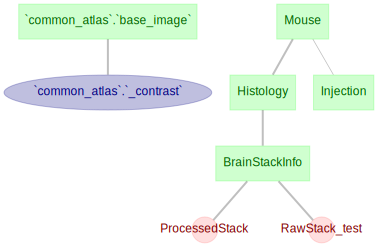

In [37]:
dj.ERD(schema)

In [ ]:
# UNUSED
@schema
class ProcessedStack(dj.Computed):
    definition = """
    -> BrainStackInfo
    """
        
    class Slice(dj.Part):
        definition = """
        -> ProcessedStack
        slice_num : int           # (int) the slice's number
        -----------
        slice_name : varchar(80)  # (Str) the slice's name
        slice_img  : blob         # (Img) the raw slice
        """

    def make(self, key):
        # Making test image
        file = open('sorted_filenames.txt')
        file_list = file.read().split('\n')
        image = np.ones((100,80))
        
        self.insert1(key)
        ProcessedStack.Slice().insert([
                dict(key, 
                     slice_num = file_list[i][1+file_list[i].index(' '):], 
                     slice_name = file_list[i][:file_list[i].index(' ')], 
                     slice_img=image)
                for i in range(0,len(file_list))  ], 
                    skip_duplicates=True)